In [32]:
from sklearn import tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic_data = pd.read_csv('train.csv')

In [3]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Correlation

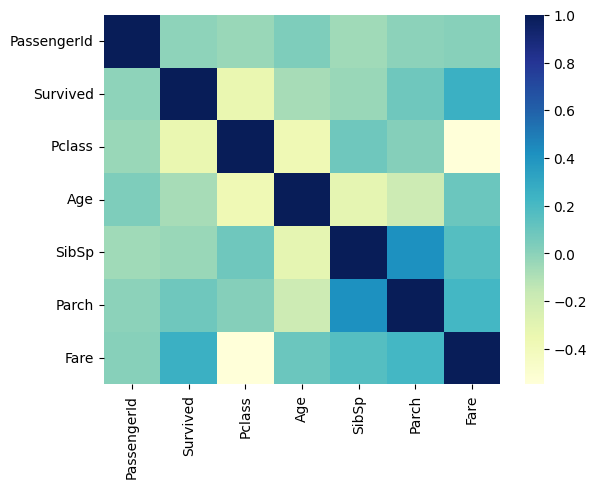

In [54]:
sns.heatmap(titanic_data.corr(), cmap="YlGnBu")
plt.show()

# Split data

In [56]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

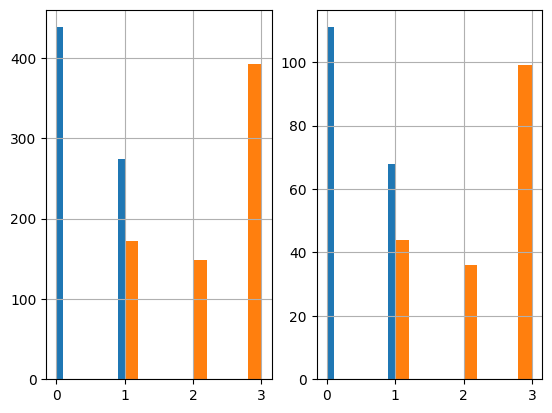

In [58]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

# Missing data and one hot encoding

In [59]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 145 to 449
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          571 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        167 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [62]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [63]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        
        column_names = ["C", "S", "Q", "N"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        
        column_names = ["Female", "Male"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        return X

In [64]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

# Pipeline

In [65]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])

In [66]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [67]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 145 to 449
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


# Preprocessing

In [69]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [71]:
clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [72]:
final_clf = grid_search.best_estimator_

In [73]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 500}

In [74]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [76]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [77]:
final_clf.score(X_data_test, y_data_test)

0.8435754189944135

# Using all data

In [78]:
final_data = pipeline.fit_transform(titanic_data)

In [79]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [80]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [81]:
prod_final_clf = grid_search.best_estimator_

In [82]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 200}

In [83]:
titanic_test_data = pd.read_csv("test.csv")

In [84]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [87]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [88]:
predictions = prod_final_clf.predict(X_data_final_test)

In [91]:
final_df = pd.DataFrame(final_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("predictions.csv", index=False)

In [90]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [5]:
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = titanic_data.Survived

In [6]:
X = pd.get_dummies(X)

In [7]:
X = X.fillna({'Age': X.Age.median()})

In [8]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [9]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [13]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [14]:
clf.score(X_train, y_train)

0.9798657718120806

In [15]:
clf.score(X_test, y_test)

0.7830508474576271

# Cross validation

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 4)

In [19]:
cross_val_score(clf, X_test, y_test, cv=5)

array([0.79661017, 0.74576271, 0.88135593, 0.77966102, 0.83050847])

# GridSearchCV

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
clf = tree.DecisionTreeClassifier()

In [22]:
params = {'criterion': ['entropy', 'gini'], 'max_depth': range(1, 30), 'min_samples_split': range(2, 600, 50), 'min_samples_leaf': range(2, 600, 50)}

In [23]:
grid_search_cv_clf = GridSearchCV(clf, params, cv=5)

In [25]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 30),
                         'min_samples_leaf': range(2, 600, 50),
                         'min_samples_split': range(2, 600, 50)})

In [26]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 52}

In [27]:
best_clf = grid_search_cv_clf.best_estimator_

In [28]:
best_clf.score(X_test, y_test)

0.8305084745762712

In [29]:
from sklearn.metrics import precision_score, recall_score

In [30]:
y_pred = best_clf.predict(X_test)

In [34]:
y_predicted_prob = best_clf.predict_proba(X_test)

In [35]:
y_pred = np.where(y_predicted_prob[:, 1] > 0.2, 1, 0)

In [36]:
precision_score(y_test, y_pred)

0.6666666666666666

In [37]:
recall_score(y_test, y_pred)

0.8421052631578947

<AxesSubplot: >

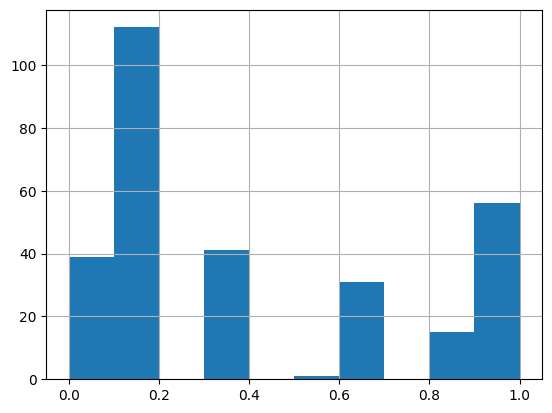

In [38]:
pd.Series(y_predicted_prob[:, 1]).hist()

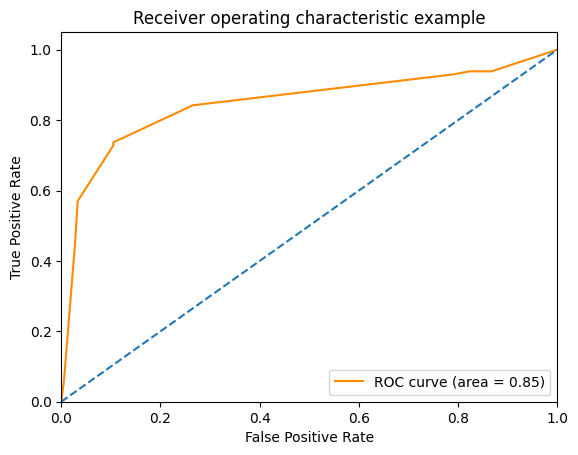

In [39]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
clf_rf = RandomForestClassifier()

In [42]:
parameters = {'n_estimators': range(2, 50, 10), 'max_depth': [2, 5, 7, 10], 'min_samples_split': range(2, 600, 50), 'min_samples_leaf': range(2, 600, 50)}

In [43]:
grid_search_cv_clf_rf = GridSearchCV(clf_rf, parameters, cv=5)

In [46]:
grid_search_cv_clf_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'min_samples_leaf': range(2, 600, 50),
                         'min_samples_split': range(2, 600, 50),
                         'n_estimators': range(2, 50, 10)})

In [47]:
grid_search_cv_clf_rf.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 32}

In [48]:
best_clf_rf = grid_search_cv_clf_rf.best_estimator_

In [49]:
best_clf_rf.score(X_test, y_test)

0.8271186440677966

In [50]:
best_clf_rf.feature_importances_

array([0.12650608, 0.09460105, 0.04132624, 0.04034775, 0.20830428,
       0.2824967 , 0.1779894 , 0.0127212 , 0.0080927 , 0.00761459])

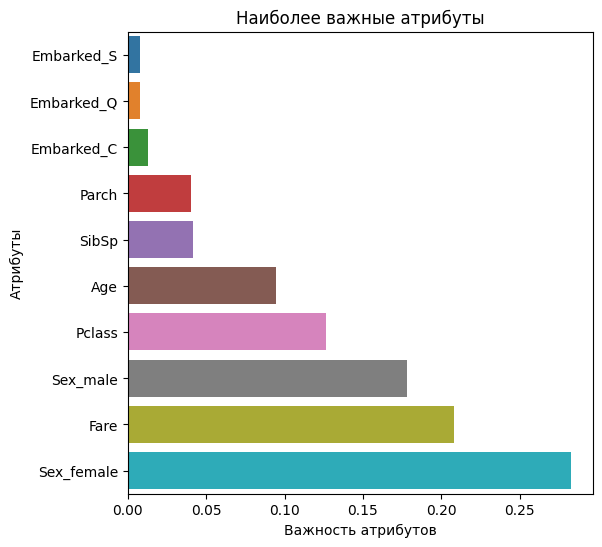

In [51]:
feature_importances_df = pd.DataFrame({'features':list(X_train.columns), 
                                       'feature_importances':  best_clf_rf.feature_importances_})\
                        .sort_values(by='feature_importances')

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=feature_importances_df.features, x=feature_importances_df.feature_importances)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()

In [52]:
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
5,Sex_female,0.282497
4,Fare,0.208304
6,Sex_male,0.177989
0,Pclass,0.126506
1,Age,0.094601
2,SibSp,0.041326
3,Parch,0.040348
7,Embarked_C,0.012721
8,Embarked_Q,0.008093
9,Embarked_S,0.007615


# Next